In [1]:
# Import required tools/tasks
from casatools import simulator, image, table, coordsys, measures, componentlist, quanta, ctsys
from casatasks import tclean, ft, imhead, listobs, exportfits, flagdata, bandpass, applycal
from casatasks.private import simutil

import os
import pylab as pl
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS


# Instantiate all the required tools
sm = simulator()
ia = image()
tb = table()
cs = coordsys()
me = measures()
qa = quanta()
cl = componentlist()
mysu = simutil.simutil()

#definiing the data area
mydata='./'

In [2]:
def plotData(msname=mydata+'sim-flat-sn25.ms', myplot='uv'):
    """
    Options : myplot='uv'
              myplot='data_spectrum'
    """
    from matplotlib.collections import LineCollection
    tb.open(msname)

    # UV coverage plot
    if myplot=='uv':
        pl.figure(figsize=(4,4))
        pl.clf()
        uvw = tb.getcol('UVW')
        pl.plot( uvw[0], uvw[1], '.')
        pl.plot( -uvw[0], -uvw[1], '.')
        pl.title('UV Coverage')
    
    # Spectrum of chosen column. Make a linecollection out of each row in the MS.
    if myplot=='data_spectrum' or myplot=='corr_spectrum' or myplot=='resdata_spectrum'  or myplot=='rescorr_spectrum' or myplot=='model_spectrum':
        dats=None
        if myplot=='data_spectrum':
            dats = tb.getcol('DATA')
        if myplot=='corr_spectrum':
            dats = tb.getcol('CORRECTED_DATA')
        if myplot=='resdata_spectrum':
            dats = tb.getcol('DATA') - tb.getcol('MODEL_DATA') 
        if myplot=='rescorr_spectrum':
            dats = tb.getcol('CORRECTED_DATA') - tb.getcol('MODEL_DATA') 
        if myplot=='model_spectrum':
            dats = tb.getcol('MODEL_DATA')
            
        xs = np.zeros((dats.shape[2],dats.shape[1]),'int')
        for chan in range(0,dats.shape[1]):
            xs[:,chan] = chan
    
        npl = dats.shape[0]
        fig, ax = pl.subplots(1,npl,figsize=(10,4))
        
        for pol in range(0,dats.shape[0]):
            x = xs
            y = np.abs(dats[pol,:,:]).T
            data = np.stack(( x,y ), axis=2)
            ax[pol].add_collection(LineCollection(data))
            ax[pol].set_title(myplot + ' \n pol '+str(pol))
            ax[pol].set_xlim(x.min(), x.max())
            ax[pol].set_ylim(y.min(), y.max())
        pl.show()


In [3]:
# Display an image using AstroPy, with coordinate system rendering.
def dispAstropy(imname=mydata+'sim-flat-sn25.im'):
        exportfits(imagename=imname, fitsimage=imname+'.fits', overwrite=True)
        hdu = fits.open(imname+'.fits')[0]
        wcs = WCS(hdu.header,naxis=2)
        fig = pl.figure()
        fig.add_subplot(121, projection=wcs)
        pl.imshow(hdu.data[0,0,:,:], origin='lower', cmap=pl.cm.viridis)
        pl.xlabel('RA')
        pl.ylabel('Dec')


# Display an image cube or a single plane image.
# For a Cube, show the image at chan 0 and a spectrum at the location of the peak in chan0.
# For a Single plane image, show the image.
def dispImage(imname=mydata+'sim-flat-sn25.im', useAstropy=False):
    ia.open(imname)
    pix = ia.getchunk()
    shp = ia.shape()
    ia.close()
    pl.figure(figsize=(10,4))
    pl.clf()
    if shp[3]>1:
        pl.subplot(121)
    if useAstropy==False:
        pl.imshow(pix[:,:,0,0]) 
        pl.title('Image from channel 0')
    else:
        dispAstropy(imname)
    if shp[3]>1:
        pl.subplot(122)
        ploc = np.where( pix == pix.max() )
        pl.plot(pix[ploc[0][0], ploc[1][0],0,:])
        pl.title('Spectrum at source peak')
        pl.xlabel('Channel')
        

In [5]:
def makeMSFrame(msname =mydata+'sim-flat-sn25.ms'):
    """ 
    Construct an empty Measurement Set that has the desired observation setup. 
    """
        
    os.system('rm -rf '+msname)
        
    ## Open the simulator
    sm.open(ms=msname);

    ## Read/create an antenna configuration. 
   
    antennalist = os.path.join( mydata ,"gmrt.cfg")

    (x,y,z,d,an,an2,telname, obspos) = mysu.readantenna(antennalist)

    ## Set the antenna configuration
    sm.setconfig(telescopename=telname,
                     x=x,
                     y=y,
                     z=z,
                     dishdiameter=d,
                     mount=['alt-az'], 
                     antname=an,
                     coordsystem='local',
                     referencelocation=me.observatory(telname));

    ## Set the polarization mode (this goes to the FEED subtable)
    sm.setfeed(mode='perfect R L', pol=['']);

    ## Set the spectral window and polarization (one data-description-id). 

    sm.setspwindow(spwname="UBand",
                   freq='300.0MHz',
                   deltafreq='390.625kHz', #frequency resolution
                   freqresolution='200.0MHz', #BW
                   nchannels=512,
                   stokes='RR LL');

    ## Setup source/field information (i.e. where the observation phase center is)
    
    sm.setfield( sourcename="fake",
                 sourcedirection=me.direction(rf='J2000', v0='05h35m17.5s',v1='-05d23m36s'));

    ## Set shadow/elevation limits (if you care). These set flags.
    sm.setlimits(shadowlimit=0.01, elevationlimit='17deg');

    ## Leave autocorrelations out of the MS.
    sm.setauto(autocorrwt=0.0);  


    sm.settimes(integrationtime='10s',
                usehourangle=True,
                referencetime=me.epoch('UTC','2017/01/09/12:27:23'));


    sm.observe(sourcename="fake",
               spwname='UBand', 
               starttime='0.0h', #taking start time from negetive causes flip in uv plot
               stoptime='+6.0h');

    ## Close the simulator
    sm.close()
    

    flagdata(vis=msname,mode='unflag')                                                  

In [6]:
makeMSFrame()

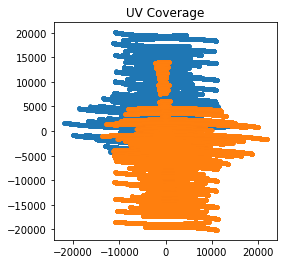

In [7]:
plotData(myplot='uv')

In [8]:
listobs(vis=mydata+'sim-flat-sn25.ms', listfile='obslist.txt', verbose=False, overwrite=True)
## print(os.popen('obslist.txt').read()) # ?permission denied?
fp = open('obslist.txt')
for aline in fp.readlines():
    print(aline.replace('\n',''))
fp.close()

           MeasurementSet Name:  /disk/Rashid/sim-band3/sim-fs-b3/sim-flat-sp/sim-flat-sn25/sim-flat-sn25.ms      MS Version 2
   Observer: CASA simulator     Project: CASA simulation  
Observation: GMRT(30 antennas)
Data records: 939600       Total elapsed time = 21600 seconds
   Observed from   09-Jan-2017/16:22:53.0   to   09-Jan-2017/22:22:53.0 (UTC)

Fields: 1
  ID   Code Name                RA               Decl           Epoch   SrcId      nRows
  0         fake                05:35:17.500000 -05.23.36.00000 J2000   0         939600
Spectral Windows:  (1 unique spectral windows and 1 unique polarization setups)
  SpwID  Name   #Chans   Frame   Ch0(MHz)  ChanWid(kHz)  TotBW(kHz) CtrFreq(MHz)  Corrs  
  0      UBand    512   TOPO     300.000       390.625    200000.0    399.8047   RR  LL
Antennas: 30 'name'='station' 
   ID=   0-5: 'C00'='P', 'C01'='P', 'C02'='P', 'C03'='P', 'C04'='P', 'C05'='P', 
   ID=  6-11: 'C06'='P', 'C08'='P', 'C09'='P', 'C10'='P', 'C11'='P', 'C12'='P', 
   

In [9]:
def makeCompList(clname_true=mydata+'sim-flat-sn25.cl'):
    os.system('rm -rf '+clname_true)
    cl.done()
    cl.addcomponent(dir='J2000 5h35m17.5s -5d23m36s', 
                        flux=0.00025,           
                        fluxunit='Jy', 
                        freq='400.0MHz', 
                        shape='point',       
                        spectrumtype="spectral index",
                        index=0.0)

    
    # Save the file
    cl.rename(filename=clname_true)
    cl.done()

In [10]:
def makeEmptyImage(imname_true=mydata+'sim-flat-sn25.im'):
    ## Define the center of the image
    radir = '05h35m17.5s'
    decdir = '-5d23m36s'
    
    ## Make the image from a shape
    ia.close()
    ia.fromshape(imname_true,[512,512,1,512],overwrite=True)
    
    ## Make a coordinate system
    cs=ia.coordsys()
    cs.setunits(['rad','rad','','Hz'])
    cell_rad=qa.convert(qa.quantity('0.4arcsec'),"rad")['value']
    cs.setincrement([-cell_rad,cell_rad],'direction')
    cs.setreferencevalue([qa.convert(radir,'rad')['value'],qa.convert(decdir,'rad')['value']],type="direction")
    cs.setreferencevalue('300.0MHz','spectral')
    cs.setreferencepixel([0],'spectral')
    cs.setincrement('390.625kHz','spectral')
    
    ## Set the coordinate system in the image
    ia.setcoordsys(cs.torecord())
    ia.setbrightnessunit("Jy/pixel")
    ia.set(0.0)
    ia.close() 

In [11]:
def evalCompList(clname=mydata+'sim-flat-sn25.cl', imname=mydata+'sim-flat-sn25.im'):
    ##  Evaluate a component list
    cl.open(clname)
    ia.open(imname)
    ia.modify(cl.torecord(),subtract=False)
    ia.close()
    cl.done()

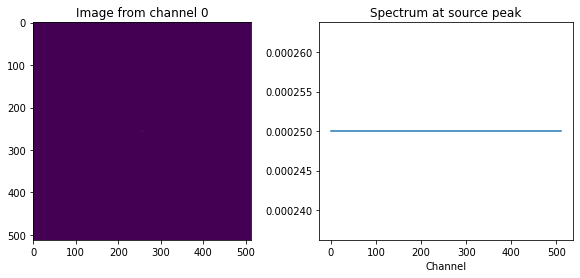

In [12]:
## Make the component list
makeCompList()

## Make an empty CASA image
makeEmptyImage()


evalCompList()

dispImage()
#dispAstropy()

In [4]:
## Use an input model sky image - widefield gridders
def predictImager(msname=mydata+'sim-flat-sn25.ms',
                  imname_true=mydata+'sim-flat-sn25.im',
                  gridder='widefield'):#'standard'):
    
    os.system('rm -rf sim_predict.*')
    
 
    tclean(vis=msname,
       startmodel=imname_true,
       imagename=mydata+'sim_predict',
       savemodel='modelcolumn',
       imsize=512,
       cell='0.4arcsec',
       specmode='cube',
       interpolation='nearest',
       start='300.0MHz',
       width='390.665kHz',
       nchan=512,
       reffreq='399.8047MHz',
       gridder=gridder,
       normtype='flatsky', 
       cfcache='sim_predict.cfcache',
       wbawp=True,      
       pblimit=0.05,    
       conjbeams=False, 
       calcres=False, 
       calcpsf=True, 
       niter=0, 
       wprojplanes=-1)

In [5]:
### Copy visibilities from the MODEL column to the data columns
### This is required when predicting using tclean or ft as they will only write to the MODEL column
def copyModelToData(msname=mydata+'sim-flat-sn25.ms'):
    tb.open(msname,nomodify=False);
    moddata = tb.getcol(columnname='MODEL_DATA');
    tb.putcol(columnname='DATA',value=moddata);

    moddata.fill(0.0);
    tb.putcol(columnname='MODEL_DATA',value=moddata);
    tb.close();

In [6]:
predictImager()

In [7]:
copyModelToData()

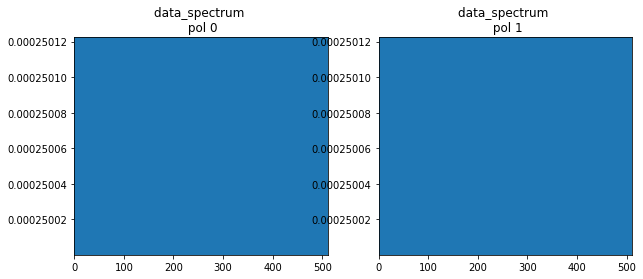

In [8]:
plotData(myplot='data_spectrum')

In [9]:
## Add Gaussian random noise 
def addNoiseSim(msname=mydata+'sim-flat-sn25.ms'):
    sm.openfromms(msname);
    sm.setseed(50)
    sm.setnoise(mode='simplenoise',simplenoise='0.25Jy');
    sm.corrupt();   
    sm.close();

In [10]:
addNoiseSim()